In [ ]:
import utils
import loader
import graphics
import pandas as pd
import numpy as np

# Usar las trazas de Simva o las de Scorm
use_scorm = False

files_path = "./trazas/simva/"
cols_to_drop = ["stored", "id", "version", "actor.account.homePage", "authority.name", "authority.homePage", "context.contextActivities.category", "context.registration", "object.definition.name.en-US", "object.definition.description.en-US", "object.definition.type", "verb.display.en-US", "verb.id", "object.objectType", "result.response", "result.score.scaled", "result.completion", "result.success"]

if use_scorm:
	files_path = "./trazas/scorm/"
	cols_to_drop = ["verb.display.en-US", "id", "stored", "version", "actor.objectType", "actor.account.homePage", "result.success", "result.completion", "context.registration", "authority.objectType", "authority.account.homePage", "authority.account.name", "authority.name", "object.definition.description.en-US", "object.definition.name.en-US", "object.objectType", "context.contextActivities.category"]

files_extension = "json"

############################
# Datos comunes
# Sacado de los JSONs
############################
all_users_df, users_individual_df_list = loader.load_all_files(files_path, files_extension, "timestamp", cols_to_drop, use_scorm)
n_users = len(users_individual_df_list)

game_starts_conditions = [("object.id", "GameStart")]
game_starts = utils.find_indices_by_conditions(all_users_df, game_starts_conditions)
game_starts = all_users_df.iloc[game_starts]
game_starts = game_starts.drop_duplicates(subset=["actor.account.name"])

gender_sexuality_combinations = [
	('male', 'heterosexual'), 
	('male', 'homosexual'), 
	('male', 'bisexual'), 
	('female', 'heterosexual'), 
	('female', 'homosexual'), 
	('female', 'bisexual')
]
demography = game_starts[["actor.account.name", "Gender", "Sexuality"]].values.tolist()

demography_info = {}
for user in demography:
	demography_info.update({user[0]: (user[1], user[2])})



##########
APARTADO 2 c i
Tiempo medio que se queda leyendo las pantallas de transición:
4.654095295536791 segundos
##########

##########
APARTADO 2 c ii
Tiempo medio que se queda leyendo cada diálogo:
##########



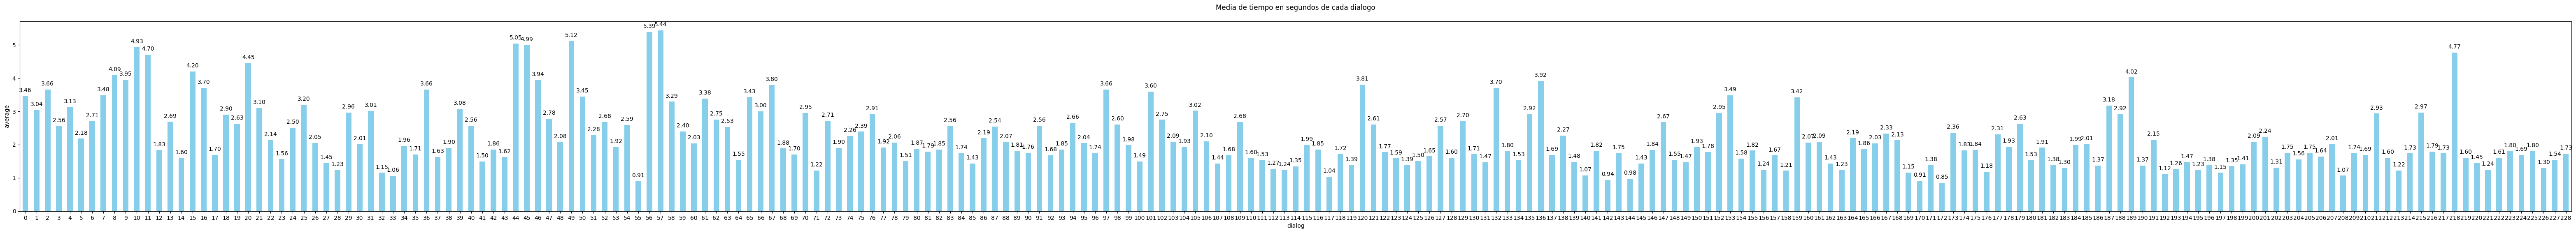

In [ ]:

############################
# APARTADO 2 c i
# Tiempo medio que se queda leyendo las pantallas de transición.
############################
def average_transition_time(users_individual_df_list):
	conditions = [("Scene", "TextOnlyScene")]
	durations = []
	for user in users_individual_df_list:
		indexes = utils.find_indices_by_conditions(user, conditions)
		index_list = list(user.index)
		for index in indexes:
			pos = index_list.index(index)
			if pos + 1 < len(index_list):
				next_idx = index_list[pos + 1]
				if user.loc[next_idx, 'object.id'] == 'EnterScene':
					value = utils.time_between_indices(user, index, next_idx)
					durations.append(value)

	return durations

durations=average_transition_time(users_individual_df_list)
mean=np.mean(durations)
utils.show_metric(
	section="2 c i",
	title="Tiempo medio que se queda leyendo las pantallas de transición",
	info=f"{mean} segundos"
)


############################
# APARTADO 2 c ii,
# Tiempo medio que se queda leyendo cada diálogo.
############################
def average_dialog_time(users_individual_df_list):
	conditions = [("object.id", "DialogStart")]
	diccionary = {}

	for user in users_individual_df_list:
		indexes = utils.find_indices_by_conditions(user, conditions)
		for index in indexes:
			end_condition= [("object.id","DialogEnd"),("Node",user.loc[index, "Node"])]
			end_index= utils.find_first_index_by_conditions(user,end_condition,index)
			if end_index:
			  key= user.loc[index, "Node"]
			  value= utils.time_between_indices(user,index, end_index)
			  if key not in diccionary:
				 diccionary[key] = []
			text= user.loc[index, "Dialog.text"]
			diccionary[key].append(value) 
			
	average  = {}

	for key, value in diccionary.items():
		average [key] = sum(value) / len(value)

	return average


average = average_dialog_time(users_individual_df_list)
text = ""
for key, value in average.items():
	text += f"Media para '{key}': {value:.2f}\n"

all_values = [v for v in average.values()]
overall_average = sum(all_values) / len(all_values)
text+= f"Media total: {overall_average:.2f}"
#print(text)


utils.show_metric(
	section="2 c ii",
	title="Tiempo medio que se queda leyendo cada diálogo",
	info=""
)
df_average = pd.DataFrame(list(average.items()), columns=['dialog', 'average'])
graphics.display_bar_chart(df_average,title="Media de tiempo en segundos de cada dialogo",ylabel="average",xlabel="dialog",bar_color="skyblue",sizex=80)


In [ ]:
import numpy as np

def dialog_time_stats(users_individual_df_list):
	# Primero, calcular tiempos por diálogo (Node)
	dialog_times = {}  # dict de Node: [lista de tiempos]
	for user in users_individual_df_list:
		starts = utils.find_indices_by_conditions(user, [("object.id", "DialogStart")])
		for idx in starts:
			node = user.loc[idx, "Node"]
			end_idx = utils.find_first_index_by_conditions(
				user, [("object.id", "DialogEnd"), ("Node", node)], idx)
			if end_idx:
				value = utils.time_between_indices(user, idx, end_idx)
				dialog_times.setdefault(node, []).append(value)

	# Calcular media y std por Node
	dialog_stats = {}
	for node, times in dialog_times.items():
		media = np.mean(times)
		std = np.std(times)
		dialog_stats[node] = (media, std)
	

	# Para cada usuario, marcar si ha "no leído" cada diálogo
	user_no_read_count = []
	total_dialogs = 0  # Contar total de diálogos posibles (por usuario)
	for user in users_individual_df_list:
		no_read_count = 0
		starts = utils.find_indices_by_conditions(user, [("object.id", "DialogStart")])
		for idx in starts:
			node = user.loc[idx, "Node"]
			end_idx = utils.find_first_index_by_conditions(
				user, [("object.id", "DialogEnd"), ("Node", node)], idx)
			if end_idx:
				value = utils.time_between_indices(user, idx, end_idx)
				media, std = dialog_stats[node]
				threshold = media - 2 * std
				if value < threshold:
					no_read_count += 1
				total_dialogs += 1
		user_no_read_count.append(no_read_count)

	# Porcentaje total de diálogos no leídos
	total_no_read = sum(user_no_read_count)
	percentage_no_read = (total_no_read / total_dialogs) * 100 if total_dialogs > 0 else 0

	#el porcentaje por usuario
	percentages_per_user = [
		(count / len(utils.find_indices_by_conditions(user, [("object.id", "DialogStart")])))*100 
		if len(utils.find_indices_by_conditions(user, [("object.id", "DialogStart")])) > 0 else 0
		for count, user in zip(user_no_read_count, users_individual_df_list)
	]

	return total_no_read, percentage_no_read, user_no_read_count, percentages_per_user

# USO:
total_no_read, percentage_no_read, user_no_read_count, percentages_per_user = dialog_time_stats(users_individual_df_list)

print(f"Número total de diálogos NO leídos: {total_no_read}")
print(f"Porcentaje total de diálogos NO leídos: {percentage_no_read:.2f}%")
print("Diálogos no leídos por usuario:", user_no_read_count)
print("Porcentaje de diálogos no leídos por usuario:", [f"{p:.1f}%" for p in percentages_per_user])
print(len(users_individual_df_list))

Número total de diálogos NO leídos: 8
Porcentaje total de diálogos NO leídos: 0.08%
Diálogos no leídos por usuario: [0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Porcentaje de diálogos no leídos por usuario: ['0.0%', '0.0%', '0.5%', '1.6%', '0.0%', '0.5%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '1.1%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.5%', '0.0%', '0.0%', '0.0%']
51


In [ ]:
import numpy as np

def dialog_time_stats(users_individual_df_list):
	# Recoger todos los tiempos por diálogo y por usuario
	dialog_times = {}  # Node -> [tiempos de todos]
	user_dialog_times = {}  # user_idx -> [(Node, tiempo)]

	for user_idx, user in enumerate(users_individual_df_list):
		starts = utils.find_indices_by_conditions(user, [("object.id", "DialogStart")])
		for idx in starts:
			node = user.loc[idx, "Node"]
			end_idx = utils.find_first_index_by_conditions(
				user, [("object.id", "DialogEnd"), ("Node", node)], idx)
			if end_idx:
				value = utils.time_between_indices(user, idx, end_idx)
				dialog_times.setdefault(node, []).append(value)
				user_dialog_times.setdefault(user_idx, []).append((node, value))

	# Calcular media y std por diálogo
	dialog_stats = {}  # Node -> (media, std)
	for node, times in dialog_times.items():
		# media = np.mean(times)
		# std = np.std(times)
		# dialog_stats[node] = (media, std)
		dialog_stats[node]= utils.find_outliers(np.sort(times),1.5,25,75)

	# Detectar diálogos no leídos por usuario
	user_no_read_info = {}  # user_idx -> [(Node, tiempo, threshold, no_leido_bool)]
	user_no_read_count = []
	user_total_count = []

	for user_idx, node_times in user_dialog_times.items():
		no_read_list = []
		no_read_count = 0
		for node, value in node_times:
			outliers = dialog_stats[node]
			threshold = outliers["lower_limit"]
			no_leido = value < threshold
			no_read_list.append((node, value, threshold, no_leido))
			if no_leido:
				no_read_count += 1
		user_no_read_info[user_idx] = no_read_list
		user_no_read_count.append(no_read_count)
		user_total_count.append(len(node_times))

	# Cálculo de porcentajes
	total_no_read = sum(user_no_read_count)
	total_dialogs = sum(user_total_count)
	percentage_no_read = (total_no_read / total_dialogs) * 100 if total_dialogs > 0 else 0

	percentages_per_user = [
		(count / total) * 100 if total > 0 else 0
		for count, total in zip(user_no_read_count, user_total_count)
	]

	return {
		"total_no_read": total_no_read,
		"percentage_no_read": percentage_no_read,
		"user_no_read_count": user_no_read_count,
		"percentages_per_user": percentages_per_user,
		"user_no_read_info": user_no_read_info,
		"dialog_stats": dialog_stats
	}

# =========================
# USO DEL CÓDIGO:
# =========================

resultados = dialog_time_stats(users_individual_df_list)

print(f"Número total de diálogos NO leídos: {resultados['total_no_read']}")
print(f"Porcentaje total de diálogos NO leídos: {resultados['percentage_no_read']:.2f}%")
print("Diálogos no leídos por usuario:", resultados["user_no_read_count"])
print("Porcentaje de diálogos no leídos por usuario:", [f"{p:.1f}%" for p in resultados["percentages_per_user"]])


conteo = sum(1 for n in resultados['percentages_per_user'] if n > 25)

print(conteo/len(resultados['percentages_per_user'])*100)

# # Si quieres ver en detalle qué diálogos no ha leído cada usuario:
# for user_idx, no_read_list in resultados["user_no_read_info"].items():
#     print(f"\nUsuario {user_idx}:")
#     for node, value, threshold, no_leido in no_read_list:
#         if no_leido:
#             print(f"  - NO leído: '{node}' (tiempo={value:.2f}s, umbral={threshold:.2f}s)")


Número total de diálogos NO leídos: 12
Porcentaje total de diálogos NO leídos: 0.12%
Diálogos no leídos por usuario: [1, 1, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Porcentaje de diálogos no leídos por usuario: ['0.5%', '0.5%', '1.0%', '3.2%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '1.1%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%']
0.0


{'Q1': np.float64(1.9869999999999999), 'Q3': np.float64(10.791), 'IQR': np.float64(8.804), 'lower_limit': np.float64(-6.817), 'upper_limit': np.float64(19.595), 'outliers': [np.float64(20.312), np.float64(23.057), np.float64(27.38), np.float64(30.514), np.float64(32.677), np.float64(36.773)]}
{'Q1': np.float64(0.8005), 'Q3': np.float64(4.7895), 'IQR': np.float64(3.9890000000000003), 'lower_limit': np.float64(-3.1885000000000003), 'upper_limit': np.float64(8.778500000000001), 'outliers': [np.float64(9.423), np.float64(15.755), np.float64(23.146)]}
{'Q1': np.float64(1.1525), 'Q3': np.float64(5.5565), 'IQR': np.float64(4.404), 'lower_limit': np.float64(-3.2515), 'upper_limit': np.float64(9.9605), 'outliers': [np.float64(12.715), np.float64(13.998), np.float64(14.064), np.float64(21.395)]}
{'Q1': np.float64(1.8315000000000001), 'Q3': np.float64(4.7940000000000005), 'IQR': np.float64(2.9625000000000004), 'lower_limit': np.float64(-1.1310000000000002), 'upper_limit': np.float64(7.75650000000

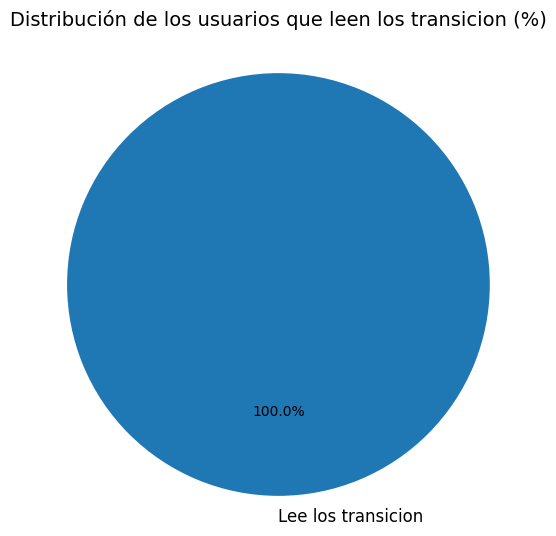

Diálogos no leídos por usuario: [87]
Porcentaje de diálogos no leídos por usuario: ['10.5%']

Usuario 0:
  - NO leído: 'Scene3Break.conversation2.root' (tiempo=0.58s, umbral=0.59s)

Usuario 1:
  - NO leído: 'Scene1Bedroom1.post.root' (tiempo=0.64s, umbral=1.01s)

Usuario 2:
  - NO leído: 'Scene1Lunch1.door.root' (tiempo=0.57s, umbral=0.72s)
  - NO leído: 'Scene1Bedroom1.post.root' (tiempo=0.56s, umbral=1.01s)

Usuario 3:
  - NO leído: 'Scene1Bedroom1.post.root' (tiempo=0.67s, umbral=1.01s)
  - NO leído: 'Scene3Break.conversation2.root' (tiempo=0.54s, umbral=0.59s)
  - NO leído: 'Scene6PortalRouteA.incorrectDoor3.root' (tiempo=0.70s, umbral=0.71s)
  - NO leído: 'Scene6PortalRouteA.main.root' (tiempo=0.62s, umbral=1.24s)
  - NO leído: 'Scene6PortalRouteA.main.comeIn' (tiempo=0.83s, umbral=1.42s)
  - NO leído: 'Scene6EndingRouteA.dad.cantAnswer' (tiempo=0.45s, umbral=0.81s)

Usuario 4:

Usuario 5:

Usuario 6:

Usuario 7:

Usuario 8:

Usuario 9:

Usuario 10:

Usuario 11:

Usuario 12:
  - N

In [14]:
import numpy as np

def transition_time_stats(users_individual_df_list, min_umbral=0.10, user_id_col="id"):
	# Recopila todos los tiempos de transición
	conditions = [("Scene", "TextOnlyScene")]
	transition_times = {} # Scene -> [tiempo de transicion]
	user_transition_times = {} # user_idx -> [(Scene,tiempo)]

	for user in users_individual_df_list:
		# Obtener el ID del usuario (modifica el nombre de la columna si es diferente)
		user_id = user.iloc[0][user_id_col] if user_id_col in user.columns else user.index[0]
		
		indexes = utils.find_indices_by_conditions(user, conditions)
		index_list = list(user.index)
		for index in indexes:
			pos = index_list.index(index)
			if pos + 1 < len(index_list):
				next_idx = index_list[pos + 1]
				if user.loc[next_idx, 'object.id'] == 'EnterScene':
					value = utils.time_between_indices(user, index, next_idx)
					scene= user.loc[next_idx, 'Scene']
					transition_times.setdefault(scene,[]).append(value)
					user_transition_times.setdefault(user_id,[]).append((scene,value))
					
	transition_outliers= {}
	
	for scene, times in transition_times.items():
		transition_outliers[scene]= utils.find_outliers(np.sort(times),1,25,75)
		print(transition_outliers[scene])

	# Detectar transicion no leídos por usuario
	user_no_read_info = {}  # user_idx -> [(Node, tiempo, threshold, no_leido_bool)]
	user_no_read_count = []
	user_total_count = []

	for user_idx, node_times in user_transition_times.items():
		no_read_list = []
		no_read_count = 0
		for node, value in node_times:
			outliers = transition_outliers[node]
			threshold = outliers["lower_limit"]
			no_leido = value < threshold or value > outliers["upper_limit"]
			no_read_list.append((node, value, threshold, no_leido))
			if no_leido:
				no_read_count += 1
		user_no_read_info[user_idx] = no_read_list
		user_no_read_count.append(no_read_count)
		user_total_count.append(len(node_times))

	# Cálculo de porcentajes
	total_no_read = sum(user_no_read_count)
	total_dialogs = sum(user_total_count)
	percentage_no_read = (total_no_read / total_dialogs) * 100 if total_dialogs > 0 else 0

	percentages_per_user = [
		(count / total) * 100 if total > 0 else 0
		for count, total in zip(user_no_read_count, user_total_count)
	]
	text= ""
	text+= f"Número total de transicion NO leídos: {total_no_read} \n"
	text+= f"Porcentaje total de transicion NO leídos: {percentage_no_read:.2f}% \n"
	# print("transicion no leídos por usuario:", user_no_read_count)
	# print("Porcentaje de transicion no leídos por usuario:", [f"{p:.1f}%" for p in percentages_per_user])
	cont = sum(1 for n in percentages_per_user if n > 25)
	p=cont/len(percentages_per_user)*100
	text+= f"Porcentaje de usuarios que No leer transicion: {p:.2f}%"

	utils.show_metric(
		section="2 c iii",
		title="Estadistica de lectura de transicion",
		info=text
	)

	graphics.display_pie_chart(
		values=[100-p,p],
		labels=["Lee los transicion", "No lee los transicion"],
		title="Distribución de los usuarios que leen los transicion (%)"
	)

	print("Diálogos no leídos por usuario:", user_no_read_count)
	print("Porcentaje de diálogos no leídos por usuario:", [f"{p:.1f}%" for p in percentages_per_user])

	for user_idx, no_read_list in resultados["user_no_read_info"].items():
		print(f"\nUsuario {user_idx}:")
		for node, value, threshold, no_leido in no_read_list:
			if no_leido:
				print(f"  - NO leído: '{node}' (tiempo={value:.2f}s, umbral={threshold:.2f}s)")


transition_time_stats(users_individual_df_list)
